# Support Vector Machines

The [support vector machine (SVM)](https://en.wikipedia.org/wiki/Support-vector_machine) is a commonly-used machine learning model. Suppose you have a collection of vectors in $\mathbb{R}^k$ called *data points*, each of which is has a *type* which is either 1 or -1.  This is called the *training data*.  You want to use these points to generate a *classifier* which, given a new data point, will tell you whether it is most likely to be of type 1 or of type -1.    For example, perhaps the points are derived from images of cats (type 1) and dogs (type -1), and you want to decide whether a new image is of a cat or of a dog.

The simplest kind of SVM finds a *hyperplane* (a line in 2D space, a place in 3D space, and so on) such that, as far as possible, all the type 1 training points are on one side of the hyperplane and all the type -1 training points are on the other side.  Given a new data point we then predict its type by simply checking which side of the hyperplane it lies on.

Of course, in general it will not be possible to find any hyperplane that has all the type 1 points on one side and all the type -1 points on the other.  In that case the method finds the "best" hyperplane in a sense made precise by the loss function defined later.

We begin with some useful `import`s.

In [3]:
import numpy as np
from scipy.optimize import *
import matplotlib.pyplot as plt
import random
from scipy.interpolate import UnivariateSpline

## Part I - Generating the Data


### generate_random_data

* generates n data points in a cluster around the point (x0, y0), with all points being within a radius, or spread, around the specified point

### plot_data

* uses the generate_random_data function to create a cluster of datapoints around a specified point, with the data points being of a specified color

* plots these datapoints in the form of a scatter graph



In [4]:
def generate_random_data(x0, y0, spread, n):
    points = []
    for i in range(n):
        x = random.uniform(x0 - spread, x0 + spread)
        y = random.uniform(y0 - spread, y0 + spread)
        point = np.array([x,y])
        points.append(point)
    return points

def plot_data(x0, y0, spread, n, c):
    data = generate_random_data(x0, y0, spread, n)
    x_data = [data[i][0] for i in range(n)]
    y_data = [data[i][1] for i in range(n)]
    plt.scatter(x_data, y_data, color = c)

## Part II - the SVM loss function

Suppose we have *training data* consisting of $n$ vectors $\mathbf{x}_1, \ldots, \mathbf{x}_n \in \mathbb{R}^k$ and that each $\mathbf{x}_i$ has a *type* $y_i$ which is either 1 or -1.  In the following diagram I've covered the type 1 points grey and the type -1 points black.

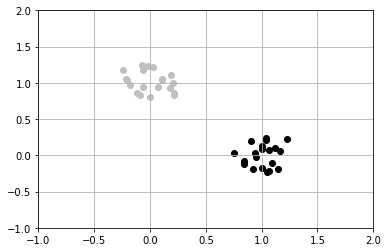

We call this data *linearly separable* if there exists a hyperplane such that all the type 1 points are on one side of the hyperplane and all the type -1 points are on the other side.  In the two-dimensional example above, the data is linearly separable: there are many possible straight lines which separate the grey and black dots.

When the data is linearly separable we can choose a hyperplane with all the type 1 points above it and all the type -1 points below it. This hyperplane can be used as a classifier: if a new point is on the same side as the type 1 points we will classify the new point as type 1, and if it is on the other side we will classify it as having type -1.

Mathematically, the classifier works like this.  Any hyperplane in $\mathbb{R}^k$ can be written as the set of all points $\mathbf{x}$ such that $\mathbf{w}^T \mathbf{x} = b$, for some vector $\mathbf{w}$ and some scalar $b$.  The hyperplane divides $\mathbb{R}^k$ into two pieces: points $\mathbf{u}$ for which $\mathbf{w}^T \mathbf{u} > b$ (above the hyperplane) and points for which $\mathbf{w}^T\mathbf{u}  < b$ (below the hyperplane). Assume that the type 1 points $\mathbf{x}_i$ satisfy $\mathbf{w}^T \mathbf{x}_i >b$. In that case, the classifier says that a new point $\mathbf{u}$ has type 1 if $\mathbf{w}^T \mathbf{u} > b$, and that it has type -1 otherwise.

When data is linearly separable there may be many different hyperplanes which separate the two types of datapoint. The choice of hyperplane affects how the classifier performs, so we must choose it carefully.  One possibility is to use the separating hyperplane with the widest *margin*.  Consider the hyperplane $\mathbf{w}^T \mathbf{x} = b$.  There is another, parallel hyperplane $\mathbf{w}^T \mathbf{x} = b+1$ above it and another, parallel hyperplane $\mathbf{w}^T \mathbf{x} = b-1$ below it.  The area between these is called the margin, and we can then look for the hyperplane that maximises the width of the margin subject to all of the positive and negative datapoints being outside it.
    



For a vector $\mathbf{u} = \begin{pmatrix} u_1 \\ \vdots \\ u_k \end{pmatrix}$ we define $||\mathbf{u}||$, the length of $\mathbf{u}$, to be $\sqrt{\sum_{i=1}^k u_i^2}$.  It turns out that the width of the margin is equal to $2/||\mathbf{w}||$, so maximising the width of the margin is equivalent to minimising $||\mathbf{w}||$ subject to the constraint that all type 1 data points $\mathbf{x}_+$ satisfy $\mathbf{w}^T \mathbf{x}_+ \geqslant b+1$ (that is, they are above the margin) and all type -1 datapoints $\mathbf{x}_-$ satisfy $\mathbf{w}^T \mathbf{x}_- \leqslant b - 1$ (that is, they are below the margin).

In general the data we work with may not be linearly separable. Consider the example below where as before, type 1 datapoints are grey and type -1 datapoints are black.




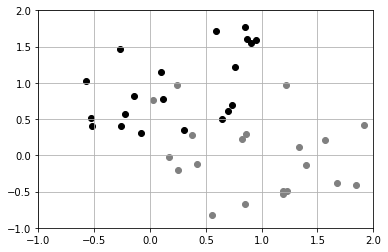

There is no straight line which separates the grey and black dots.  To help us make a classifier, recall that a vector $\mathbf{u}$ lies above the margin if $\mathbf{w}^T \mathbf{u} \geqslant b + 1$ and below it if $\mathbf{w}^T \mathbf{u} \leqslant b - 1$.  A type 1 point $\mathbf{x}_i$ is above the margin if $\mathbf{w}^T\mathbf{x}_i \geqslant b+1$, that is, $\mathbf{w}^T\mathbf{x}_i - b \geqslant 1$ and a type -1 point $\mathbf{x}_i$ is below the margin if $\mathbf{w}^T \mathbf{x}_i \leqslant b - 1$, that is $\mathbf{w}^T\mathbf{x}_i -b\geqslant 1$.  Letting $y_i=1$ if $\mathbf{x}_i$ is type 1 and $y_i=-1$ if $\mathbf{x}_i$ is type -1, we can summarise this by saying all data points $\mathbf{x}_i$ are on the correct side of the margin if and only if all of the inequalities

$$ y_i(\mathbf{w}^T \mathbf{x}_i -b) \geq 1$$

are true, or equivalently, if $1-y_i(\mathbf{w}^T \mathbf{x}_i - b) \leq 0$ for all $i$. Thus the sum

$$ \sum_{i=1}^n \max(0, 1-y_i(\mathbf{w}^T \mathbf{x}_i - b)) $$

is a nonnegative quantity that is zero if all data points are on the correct sides of the margins $\mathbf{w}^T \mathbf{x}  =b \pm 1$ and which gets bigger as points get further away from the correct side of the margin.  This is called the [hinge loss](https://en.wikipedia.org/wiki/Hinge_loss)

The SVM classifier then needs to make a tradeoff between making $||\mathbf{w}||$ small and making $$ \sum_{i=1}^n \max(0, 1-y_i(\mathbf{w}^T \mathbf{x}_i - b)) $$ small so that points are close to being on the right side of the margins.  It does this by choosing a constant $\lambda$ and minimizing the **loss function**

$$\lambda ||\mathbf{w}||^2 + \frac{1}{n}\sum_{i=1}^n \max(0, 1-y_i(\mathbf{w}^T \mathbf{x}_i - b)).$$

The parameter $\lambda$ determines the tradeoff between margin size and classification error.  If we don't mind having a small margin but hate having points on the wrong side of the margin we make $\lambda$ small; if we absolutely must have a big margin but don't care about a few mis-classified training points we make $\lambda$ big. You can read more details about this loss function and some applications of the SVM on [Andrew Zisserman](https://www.robots.ox.ac.uk/~az/lectures/ml/index.html)'s [lecture slides](https://www.robots.ox.ac.uk/~az/lectures/ml/lect2.pdf).



### loss

* data is a list of generated data points, while bw is a vector who's entries form the hyperplane $\mathbf{w}^T \mathbf{x} = b$, where bw[0] = b and bw[1], bw[2] are the entries of the vector w

* calculates the loss value using the the following formula:
$$\lambda ||\mathbf{w}||^2 + \frac{1}{n}\sum_{i=1}^n \max(0, 1-y_i(\mathbf{w}^T \mathbf{x}_i - b)).$$





 , 



In [5]:
def loss(bw, data):
    b = bw[0]
    l = 0.01
    w = np.array([bw[1],bw[2]])
    
    #data is a list of data points
    #each data point is a dictionary with keys: data point and type, where the values will be, respectively, a row vector (1-dimentional array) containg the coordinates of the data point and an integer (+ or - 1)
    
    hinge_loss = 0
    for i in range(len(data)):
            hinge_loss += max(0,1-data[i]['type']*(np.inner(w,data[i]['data point'])-b))
    magnitude = np.linalg.norm(w)
    return l*(magnitude)+(hinge_loss/len(data))

## Part III - putting it all together


### svm_classifier

* generates two clusters of data points, one centred around the `greyCentre` and the other around the `black`, which is then sorted according to type (type 1 or type -1)

* calculates the minimum value of the loss function using `scipy.optimize.minimize`

* creates the hyperplane and margins depending on the loss value, before plotting them along with the generated data


In [6]:
def svm_classifier(n, greyCentre, blackCentre, spread):  
    
    #generating the data
    black_data = generate_random_data(blackCentre[0], blackCentre[1], spread, n)
    sorted_black_data = []
    for i in range(len(black_data)):
        sorted_black_data.append({})
        sorted_black_data[i]["type"] = -1
        sorted_black_data[i]["data point"] = black_data[i]
    
    grey_data = generate_random_data(greyCentre[0], greyCentre[1], spread, n)
    sorted_grey_data = []
    for i in range(len(grey_data)):
        sorted_grey_data.append({})
        sorted_grey_data[i]["type"] = 1
        sorted_grey_data[i]["data point"] = grey_data[i]
    
    #plotting the points
    plot_data(blackCentre[0], blackCentre[1], spread, n, "black")
    plot_data(greyCentre[0], greyCentre[1], spread, n, "grey")        
    
    #minimising the loss function
    data = sorted_black_data
    data.extend(sorted_grey_data)
    loss_fun = minimize(fun=loss, args = data, x0 = [0,0,0])
    
    #creating the hyperplane
    minimum_x=min(min(black_data[i][0] for i in range(len(black_data))),min(grey_data[i][0] for i in range(len(grey_data))))
    maximum_x=max(max(black_data[i][0] for i in range(len(black_data))),max(grey_data[i][0] for i in range(len(grey_data))))
    xs=np.linspace(minimum_x,maximum_x,100)
    ys=[(loss_fun.x[0]-loss_fun.x[1]*c)/loss_fun.x[2] for c in xs]
    plt.plot(xs,ys, color= "black")
    
    #creating the margins
    zs=[(loss_fun.x[0] - 1 -loss_fun.x[1]*c)/loss_fun.x[2] for c in xs]
    ws=[(loss_fun.x[0] + 1 -loss_fun.x[1]*c)/loss_fun.x[2] for c in xs]
    plt.plot(xs,ws, "--", color = "grey", label = "")
    plt.plot(xs,zs,"--", color = "grey")
    plt.title("SVM model")
    plt.xlabel("x values")
    plt.ylabel("y values")


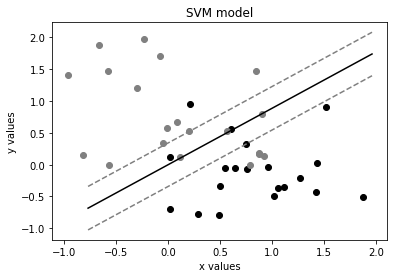

In [7]:
svm_classifier(20, [0, 1], [1, 0], 1)

## Part IV - Experiments

### minimize_loss

* calculates the minimum of the loss function for the given parameters (averaged over 100 trials)


### log_graph

* creates a scatter plot of the two datasets (data for the minimum loss - the dependent variable - and data for the independent variable)

* plots a line of best fit that underlines the relationship formed by the data

* plots a logarithmic curve that also serves to portray relationships in the data. 

A logarithmic relation appears to be most fitting for all of these experiments, with the minimum loss appearing as a decreasing function that approaches some particular value, which varies depending on the choice of the independent variable.


### Spread v minimum loss

In [1]:
def minimize_loss(n, greyCentre, blackCentre, spread, l = 0.01, expo = 2, trials = 100):
    loss_val = 0
    for i in range(trials):
        def loss(bw, data):
            b = bw[0]
            w = np.array([bw[1],bw[2]])

            hinge_loss = 0
            for i in range(len(data)):
                    hinge_loss += max(0,1-data[i]['type']*(np.inner(w,data[i]['data point'])-b))
            magnitude = (sum(abs(i) ** expo for i in w))
            return l*(magnitude)+(hinge_loss/len(data))

        grey_data = generate_random_data(greyCentre[0], greyCentre[1], spread, n)
        sorted_grey_data = []
        for i in range(len(grey_data)):
            sorted_grey_data.append({})
            sorted_grey_data[i]["type"] = 1
            sorted_grey_data[i]["data point"] = grey_data[i]

        black_data = generate_random_data(blackCentre[0], blackCentre[1], spread, n)
        sorted_black_data = []
        for i in range(len(black_data)):
            sorted_black_data.append({})
            sorted_black_data[i]["type"] = -1
            sorted_black_data[i]["data point"] = black_data[i]      

        data = sorted_grey_data
        data.extend(sorted_black_data)
        loss_fun = minimize(loss, [0,0,0], args= data)
        loss_val += loss_fun.fun
        

    return loss_val/iterations

In [29]:
x1 = np.linspace(0, 5, num = 100).astype(float)
y1 = [minimize_loss(20, [0, 1], [1, 0], i) for i in x1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


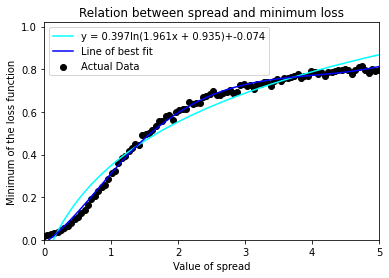

In [50]:
def log_graph(data1, data2):
    def lobf(x,a,b,c,d):
        return a*np.log(b*x + c) + d

    constants = curve_fit(f = lobf, xdata = data1, ydata = data2)
    a_fit = constants[0][0]
    b_fit = constants[0][1]
    c_fit = constants[0][2]
    d_fit = constants[0][3]

    xs = np.linspace(0, max(data1), len(data1)*5)
    fit = [lobf(x, a_fit, b_fit, c_fit, d_fit) for x in xs]

    s = UnivariateSpline(np.array(data1), np.array(data2))
    s.set_smoothing_factor(0.02)
    plt.scatter(data1, data2, color = "black", label = "Actual Data")
    plt.plot(xs, fit, 'cyan', label = f"y = {a_fit.round(3)}ln({b_fit.round(3)}x + {c_fit.round(3)})+{d_fit.round(3)}")
    plt.xlim(0,max(data1))
    plt.ylim(0,max(data2)*1.25)
    plt.plot(data1, s(data1), color="blue", label= "Line of best fit")
    return

log_graph(x1, y1)
plt.xlabel("Value of spread")
plt.ylabel("Minimum of the loss function")
plt.title("Relation between spread and minimum loss")
plt.legend()



### Number of points v minimum loss

In [32]:
x2 = np.linspace(1, 200, num = 100).astype(int)
y2 = [minimize_loss(i, [0,1], [1,0], 1) for i in x2]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


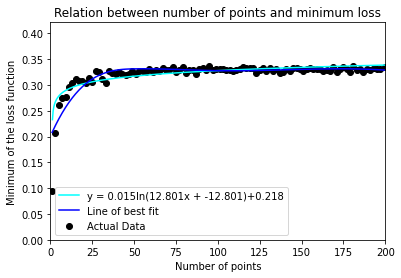

In [44]:
log_graph(x2, y2)
plt.xlabel("Number of points")
plt.ylabel("Minimum of the loss function")
plt.title("Relation between number of points and minimum loss")
plt.legend()

### Regularisation parameter (lambda) v minimum loss


In [46]:
x3 = np.linspace(0.01, 2, num = 200).astype(float)
y3 = [minimize_loss(20, [0,1], [1,0], 1, l=i) for i in x3]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


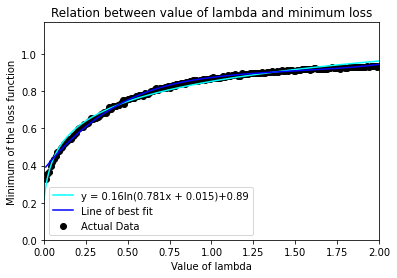

In [49]:
log_graph(x3, y3)
plt.xlabel("Value of lambda")
plt.ylabel("Minimum of the loss function")
plt.title("Relation between value of lambda and minimum loss")
plt.legend()